In [143]:
from itertools import combinations
from math import factorial
from typing import Tuple

import numpy as np
from tqdm.notebook import tqdm 
import seaborn as sns
from matplotlib import pyplot as plt
from scipy.stats import linregress

from src.datasets.utils import get_dataset
from src.estimator.RR import RRClient
from src.estimator.SM import SMClient
from src.server import Server

In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
N = 50
num_samples = np.random.randint(1000, 2000, size=N)
data = get_dataset('mnist', num_samples)

clients = []
for i in range(N):
    clients.append(RRClient(i, data[i], .0, lambda x: 1 / (1 + x)))

print('Start aggregating')
server = Server(clients)
W = server.aggregate(unbiased=True)
C = (W.T - W).sum(axis=0)

print('Compute gains')
gains = []
for i in range(N):
    gains.append(clients[i].gain(server.mtl[i]))

In [ ]:
sns.regplot(x=server.vars, y=gains, ci=None, line_kws={"color": "red"})

In [ ]:
C_bis = C - np.min(C)
C_bis = C_bis / np.max(C_bis)

In [ ]:
sns.regplot(x=C_bis, y=gains, ci=None, line_kws={"color": "red"})

# Practical Scalar Mean

In [28]:
N = 1000
num_samples = np.random.randint(1000, 10000, size=N)
MU = 50
SIGMA = 2
mus = np.random.normal(MU, SIGMA, size=N)

clients = []
for i in range(N):
    clients.append(SMClient(i, num_samples[i], mus[i], lambda x: 1 / (1 + x)))

print('Start aggregating')
server = Server(clients)
W = server.aggregate(unbiased=True)

print('Compute gains')
gains = []
for i in range(N):
    gains.append(clients[i].gain(server.mtl[i]))

Start aggregating
Compute gains


In [29]:
local_mse = [clients[i].mse(server.local[i]) for i in range(N)]
mtl_mse = [clients[i].mse(server.mtl[i]) for i in range(N)]

In [30]:
C = (W.T - W).sum(axis=0)
C_bis = C - np.min(C)
C_bis = C_bis / np.max(C_bis)

Slope: -5.238609118888383e-07
Intercept: 0.00519782129353912


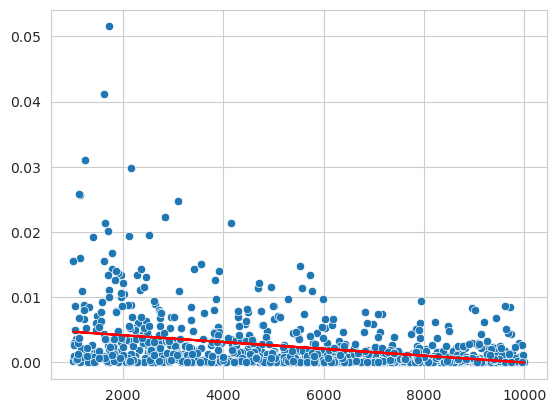

In [31]:
x, y = num_samples, local_mse
sns.scatterplot(x=x, y=y)

# Fit linear regression line
slope, intercept, r_value, p_value, std_err = linregress(x, y)

# Plot the regression line
plt.plot(x, slope * np.array(x) + intercept, color='red')

print("Slope:", slope)
print("Intercept:", intercept)

# Show plot
plt.show()

In [ ]:
x, y = local_mse, gains
sns.scatterplot(x=x, y=y)

# Fit linear regression line
slope, intercept, r_value, p_value, std_err = linregress(x, y)

# Plot the regression line
plt.plot(x, slope * np.array(x) + intercept, color='red')

print("Slope:", slope)
print("Intercept:", intercept)

# Show plot
plt.show()

In [ ]:
x, y = C_bis, gains
sns.scatterplot(x=x, y=y)

# Fit linear regression line
slope, intercept, r_value, p_value, std_err = linregress(x, y)

# Plot the regression line
plt.plot(x, slope * np.array(x) + intercept, color='red')

print("Slope:", slope)
print("Intercept:", intercept)

# Show plot
plt.show()

## With C penalizer

In [ ]:
def inc(id: int, W: np.ndarray) -> float:
    C = (W.T - W).sum(axis=0)
    C_bis = C - np.min(C)
    C_bis = C_bis / np.max(C_bis)
    return C_bis[id].item()

In [ ]:
print('Start aggregating')
server = Server(clients)
W = server.aggregate(unbiased=True, inc=inc)

print('Compute gains')
gains_reg = []
for i in range(N):
    gains_reg.append(clients[i].gain(server.mtl[i]))

In [ ]:
local_mse_reg = [clients[i].mse(server.local[i]) for i in range(N)]
mtl_mse_reg = [clients[i].mse(server.mtl[i]) for i in range(N)]

In [ ]:
x, y = local_mse_reg, gains_reg
sns.scatterplot(x=x, y=y)

# Fit linear regression line
slope, intercept, r_value, p_value, std_err = linregress(x, y)

# Plot the regression line
plt.plot(x, slope * np.array(x) + intercept, color='red')

print("Slope:", slope)
print("Intercept:", intercept)

# Show plot
plt.show()

In [ ]:
x, y = C_bis, gains_reg
sns.scatterplot(x=x, y=y)

# Fit linear regression line
slope, intercept, r_value, p_value, std_err = linregress(x, y)

# Plot the regression line
plt.plot(x, slope * np.array(x) + intercept, color='red')

print("Slope:", slope)
print("Intercept:", intercept)

# Show plot
plt.show()

# Theoretical Exemple Scalar Mean

In [147]:
N = 50
num_samples = np.random.randint(100, 1000, size=N)
MU = 50
SIGMA = 2
mus = np.random.normal(MU, SIGMA, size=N)
sigmas = np.random.random(size=N) * 2 + 2

V = np.eye(N) * sigmas
C = mus.reshape((N, 1)) @ mus.reshape(N, 1).T
W = C @ np.linalg.inv(C + V)

C = (W.T - W).sum(axis=0)
C_bis = C - np.min(C)
C_bis = C_bis / np.max(C_bis)

utility = lambda x: 10 / (1 + x)
local_mse = sigmas ** 2 / num_samples
mtl_mse = mus ** 2 / (1 + (mus ** 2 / local_mse).sum())
gains = utility(mtl_mse) - utility(local_mse)

In [146]:
E_cache = {}
u_E_cache = {}
fac_cache = {}

def val(indices: Tuple, idx: int) -> float:
    np_indices = np.array(list(indices))
    if indices in E_cache:
        E = E_cache[indices]
    else:
        E = (mus[np_indices] ** 2 * num_samples[np_indices] / sigmas[np_indices] ** 2).sum()
        E_cache[indices] = E
        
    if indices in u_E_cache:
        u_E = u_E_cache[indices]
    else:
        u_E = (utility(mus[np_indices] ** 2 / (1 + E))).sum()
        u_E_cache[indices] = u_E
    
    indices_i = indices + (idx, )
    if indices_i in E_cache:
        E_i = E_cache[indices_i]
    else:
        E_i = E + (mus[idx] ** 2 * num_samples[idx] / sigmas[idx] ** 2)
        E_cache[indices_i] = E_i
        
    if len(np_indices) == 1:
        return (utility(mus[np_indices] ** 2 / (1 + E_i))).sum() - utility(
            (sigmas[np_indices] ** 2 / num_samples[np_indices]).item())
    else:
        return (utility(mus[np_indices] ** 2 / (1 + E_i))).sum() - u_E

def factorial_sp(n: int) -> int:
    if n in fac_cache:
        return fac_cache[n]
    else:
        val = factorial(n)
        fac_cache[n] = val
        return val

def shapley_value(idx: int):
    res = 0
    for i in tqdm(range(1, N - 1), position=2, leave=False):
        for comb in tqdm(combinations([j for j in range(N) if j != idx], i), position=3, leave=False):
            res += factorial_sp(len(comb)) * factorial_sp(N - len(comb) - 1) * val(comb, idx)

    return res / factorial(N)

shap_val = list(tqdm(map(lambda x: shapley_value(x), range(N)), total=N, position=1))

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]


KeyboardInterrupt



In [42]:
gains.shape, local_mse.shape, mtl_mse.shape, C.shape, C_bis.shape, W.shape

((100,), (100,), (100,), (100,), (100,), (100, 100))

Slope: -0.013269320805102099
Intercept: 0.023798679410672822


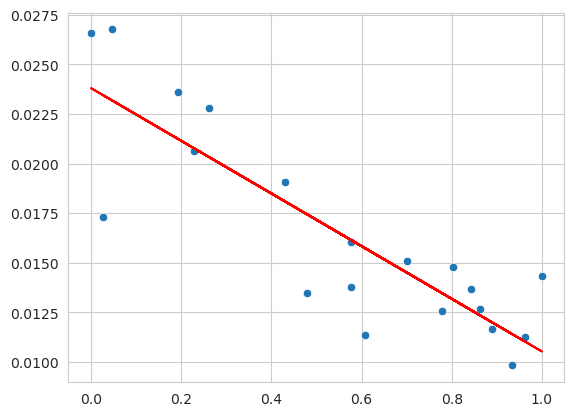

In [134]:
x, y = C_bis, shap_val
sns.scatterplot(x=x, y=y)

# Fit linear regression line
slope, intercept, r_value, p_value, std_err = linregress(x, y)

# Plot the regression line
plt.plot(x, slope * np.array(x) + intercept, color='red')

print("Slope:", slope)
print("Intercept:", intercept)

# Show plot
plt.show()

Slope: 9.016520016490185
Intercept: 0.012110964668803237


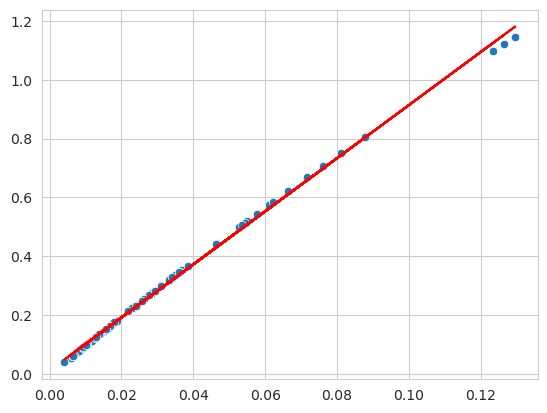

In [44]:
x, y = local_mse, gains
sns.scatterplot(x=x, y=y)

# Fit linear regression line
slope, intercept, r_value, p_value, std_err = linregress(x, y)

# Plot the regression line
plt.plot(x, slope * np.array(x) + intercept, color='red')

print("Slope:", slope)
print("Intercept:", intercept)

# Show plot
plt.show()

Slope: 0.4347684915345632
Intercept: 0.007617390335813545


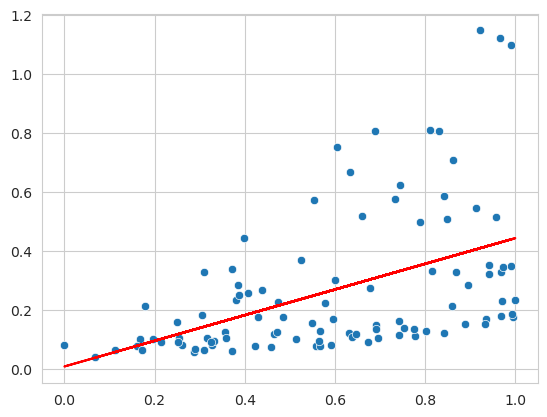

In [45]:
x, y = C_bis, gains
sns.scatterplot(x=x, y=y)

# Fit linear regression line
slope, intercept, r_value, p_value, std_err = linregress(x, y)

# Plot the regression line
plt.plot(x, slope * np.array(x) + intercept, color='red')

print("Slope:", slope)
print("Intercept:", intercept)

# Show plot
plt.show()

## With C regularizer

Slope: 0.04747184746326676
Intercept: -5.4352892241604084e-05


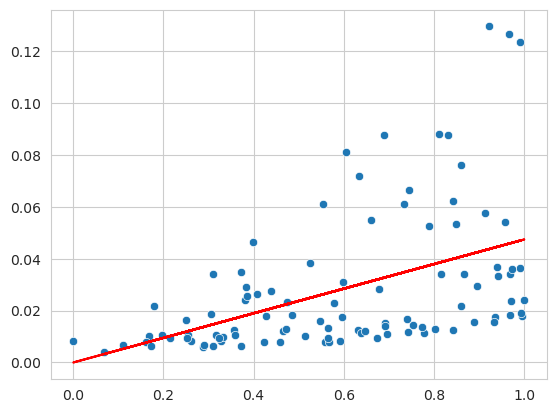

In [46]:
x, y = C_bis, local_mse
sns.scatterplot(x=x, y=y)

# Fit linear regression line
slope, intercept, r_value, p_value, std_err = linregress(x, y)

# Plot the regression line
plt.plot(x, slope * np.array(x) + intercept, color='red')

print("Slope:", slope)
print("Intercept:", intercept)

# Show plot
plt.show()

In [47]:
mtl_mse = mus ** 2 / (1 + (mus ** 2 / local_mse).sum()) + C_bis * local_mse
gains_C_reg = utility(mtl_mse) - utility(local_mse)

Slope: -0.08355747668154656
Intercept: 0.10444343802804526


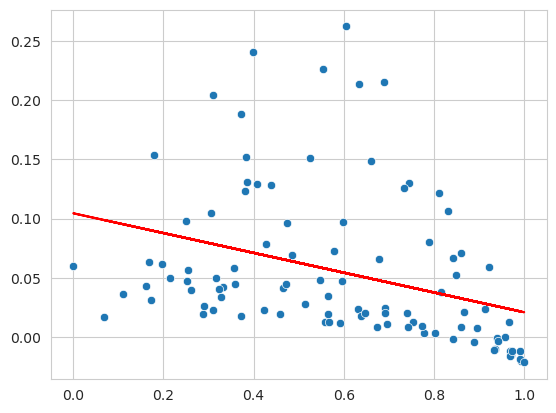

In [49]:
x, y = C_bis, gains_C_reg - 2e-2
sns.scatterplot(x=x, y=y)

# Fit linear regression line
slope, intercept, r_value, p_value, std_err = linregress(x, y)

# Plot the regression line
plt.plot(x, slope * np.array(x) + intercept, color='red')

print("Slope:", slope)
print("Intercept:", intercept)

plt.show()

Slope: 0.03748724336408869
Intercept: -0.00774470822131728


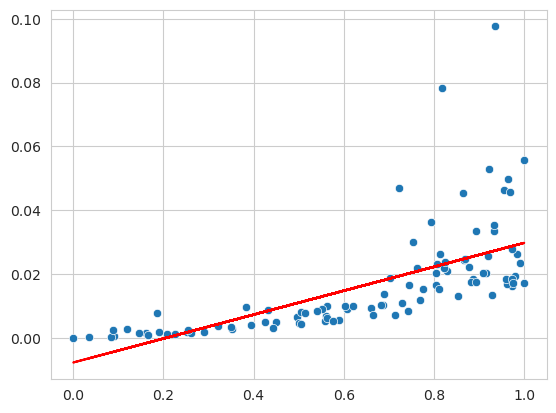

In [27]:
x, y = C_bis, np.abs(gains - gains_C_reg)
sns.scatterplot(x=x, y=y)

# Fit linear regression line
slope, intercept, r_value, p_value, std_err = linregress(x, y)

# Plot the regression line
plt.plot(x, slope * np.array(x) + intercept, color='red')

print("Slope:", slope)
print("Intercept:", intercept)

# Show plot
plt.show()

Slope: 0.11468688040433414
Intercept: 0.004217974488599448


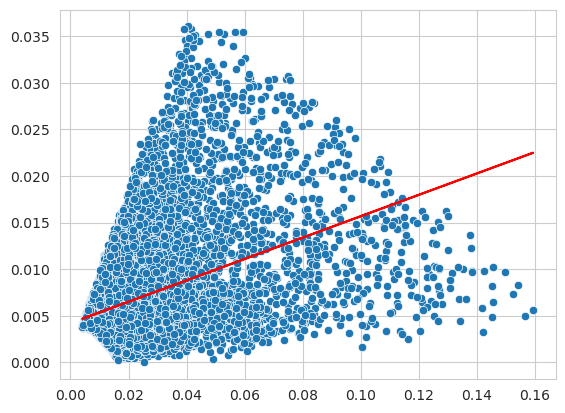

In [18]:
x, y = local_mse, gains_C_reg
sns.scatterplot(x=x, y=y)

# Fit linear regression line
slope, intercept, r_value, p_value, std_err = linregress(x, y)

# Plot the regression line
plt.plot(x, slope * np.array(x) + intercept, color='red')

print("Slope:", slope)
print("Intercept:", intercept)

# Show plot
plt.show()